# 03E. Bifurcation for two-variable systems

### Mingyang Lu

### 1/5/2024

##  Geenerating bifurcation diagram

Here, we consider the same toggle switch circuit but with slightly modified parameters. The rate equations have two variables $X$ and $Y$ and two parameters $g_X$ and $k$.

\begin{cases} \frac{dX}{dt} = f_X(X, Y, g_X, k) = 5 + g_X\frac{1}{1+(Y/100)^4} - kX \\
              \frac{dY}{dt} = f_Y(X, Y, g_X, k) = 5 + 50\frac{1}{1+(X/100)^4} - kY  \end{cases}

We will identify bifurcation diagrams by varying either $g_X$ or $k$.

In [1]:
import numpy as np
from scipy.linalg import eig

# ODE terms
def fx(X, Y, gX, k):
    return 5 + gX / (1 + (Y / 100) ** 4) - k * X

def fy(X, Y, gX, k):
    return 5 + 50 / (1 + (X / 100) ** 4) - k * Y

# nullcline can be determined by separation of variables
def null_fx(gX, k, X_range, Y_range):
    Y_all = np.linspace(Y_range[0], Y_range[1], 1000)
    X_all = (5 + gX / (1 + (Y_all / 100) ** 4)) / k
    ind = np.where((X_all - X_range[0]) * (X_all - X_range[1]) <= 0)[0]
    results = np.column_stack((X_all[ind], Y_all[ind]))
    return results

def null_fy(gX, k, X_range, Y_range):
    X_all = np.linspace(X_range[0], X_range[1], 1000)
    Y_all = (5 + 50 / (1 + (X_all / 100) ** 4)) / k
    ind = np.where((Y_all - Y_range[0]) * (Y_all - Y_range[1]) <= 0)[0]
    results = np.column_stack((X_all[ind], Y_all[ind]))
    return results

# find all intersections
def find_intersection_all_fast(lineA, lineB, dxdt, dydt):
    small = 1e-3
    lineA_ind = np.where(dydt * np.append(dydt[1:], np.nan) <= small)[0]
    lineB_ind = np.where(dxdt * np.append(dxdt[1:], np.nan) <= small)[0]
    lines_all = np.array(np.meshgrid(lineA_ind, lineB_ind)).T.reshape(-1, 2)

    def find_intersection_single(inds):
        return find_intersection(lineA, lineB, inds[0], inds[1])

    results = np.apply_along_axis(find_intersection_single, 1, lines_all)
    intersections = results[results[:, 2] == 1, :2]

    return intersections

def find_intersection(lineA, lineB, nA, nB):
    dAX = lineA[nA + 1, 0] - lineA[nA, 0]
    dAY = lineA[nA + 1, 1] - lineA[nA, 1]
    
    dBX = lineB[nB + 1, 0] - lineB[nB, 0]
    dBY = lineB[nB + 1, 1] - lineB[nB, 1]
    
    dABX = lineB[nB, 0] - lineA[nA, 0]
    dABY = lineB[nB, 1] - lineA[nA, 1]
    
    d = dAX * dBY - dAY * dBX
    
    alpha = (dABX * dBY - dABY * dBX) / d
    beta = (dABX * dAY - dABY * dAX) / d
    
    if 0 <= alpha * (1 - alpha) <= 1 and 0 <= beta * (1 - beta) <= 1:
        intersection = np.array([(1 - alpha) * lineA[nA, 0] + alpha * lineA[nA + 1, 0],
                                  (1 - alpha) * lineA[nA, 1] + alpha * lineA[nA + 1, 1], 
                                 1])
    else:
        intersection = np.array([alpha, beta, 0])
    
    return intersection

def stability_v2(func_fx, func_fy, gX, k, ss):
    delta = 0.001
    delta2 = delta * 2
    func_fx_current = func_fx(ss[0], ss[1], gX, k)
    func_fy_current = func_fy(ss[0], ss[1], gX, k)
    
    dfxdx = (func_fx(ss[0] + delta, ss[1], gX, k) - func_fx_current) / delta2
    dfxdy = (func_fx(ss[0], ss[1] + delta, gX, k) - func_fx_current) / delta2
    dfydx = (func_fy(ss[0] + delta, ss[1], gX, k) - func_fy_current) / delta2
    dfydy = (func_fy(ss[0], ss[1] + delta, gX, k) - func_fy_current) / delta2
    
    jacobian = np.array([dfxdx, dfydx, dfxdy, dfydy]).reshape((2, 2))
    lambda_values = eig(jacobian)[0]
    
    if np.iscomplex(lambda_values[0]):
        if np.real(lambda_values[0]) < 0:
            stability = 4  # stable spiral
        else:
            stability = 5  # unstable spiral
    else:
        if (lambda_values[0] < 0) and (lambda_values[1] < 0):
            stability = 1  # stable
        elif (lambda_values[0] >= 0) and (lambda_values[1] >= 0):
            stability = 2  # unstable
        else:
            stability = 3  # saddle
    
    return stability

def find_steady_states(gX, k, X_range, Y_range):
    line_1 = null_fx(gX, k, X_range, Y_range)
    line_2 = null_fy(gX, k, X_range, Y_range)
    
    dxdt = fx(line_2[:, 0], line_2[:, 1], gX, k)  # dX/dt along the nullcline dY/dt = 0
    dydt = fy(line_1[:, 0], line_1[:, 1], gX, k)  # dY/dt along the nullcline dX/dt = 0
    
    ss = find_intersection_all_fast(line_1, line_2, dxdt, dydt)
    
    ss_with_stability = np.apply_along_axis(
        lambda ss: np.concatenate([ss, [stability_v2(fx, fy, gX, k, ss)]]), 1, ss)
    
    return ss_with_stability

## Saddle-node bifurcation

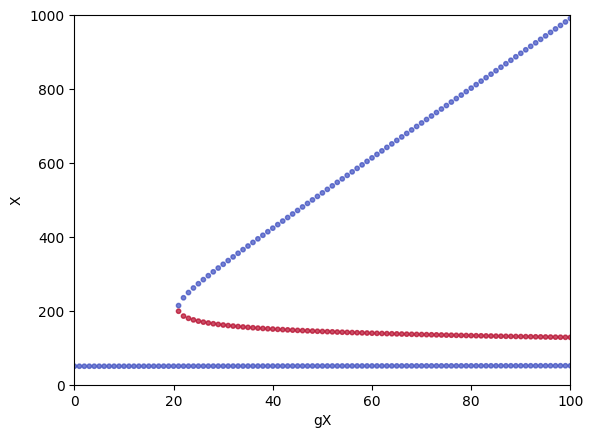

In [2]:
import matplotlib.pyplot as plt

X_range = [0, 1000]
Y_range = [0, 1000]
gX = 50
k = 0.1

ss_all = np.empty((0, 4))

for gX in range(0, 101, 1):
    ss = find_steady_states(gX, k, X_range, Y_range)
    ss_with_gX = np.column_stack((np.full((ss.shape[0], 1), gX), ss))
    ss_all = np.vstack((ss_all, ss_with_gX))

plt.scatter(ss_all[:, 0], ss_all[:, 1], c=ss_all[:, 3], cmap='coolwarm',
            marker='o', s=10, alpha=0.7)
plt.xlabel("gX")
plt.ylabel("X")
plt.xlim(0, 100)
plt.ylim(0, 1000)

plt.show()

## Pitchfork bifurcation

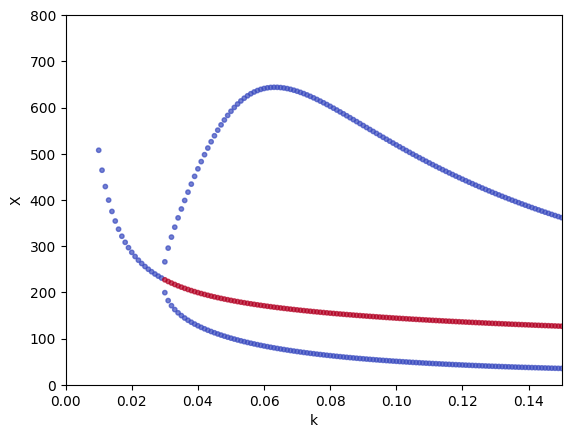

In [3]:
import matplotlib.pyplot as plt

X_range = [0, 1000]
Y_range = [0, 1000]
gX = 50
k = 0.1

ss_all = np.empty((0, 4))

for k in np.arange(0.01, 0.151, 0.001):
    ss = find_steady_states(gX, k, X_range, Y_range)
    ss_with_k = np.column_stack((np.full((ss.shape[0], 1), k), ss))
    ss_all = np.vstack((ss_all, ss_with_k))

plt.scatter(ss_all[:, 0], ss_all[:, 1], c=ss_all[:, 3], cmap='coolwarm',
            marker='o', s=10, alpha=0.7)
plt.xlabel("k")
plt.ylabel("X")
plt.xlim(0, 0.15)
plt.ylim(0, 800)

plt.show()